# Niwot Analysis 
* Conditional Probability
* Scatter Plots
* Stacked Function and Plots 

## Import packages 

In [1]:
# import packages 
%matplotlib widget
# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

# interactive plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

In [2]:
import seaborn as sns # a module that adds some plotting capabilities and makes your plots look better
import matplotlib as mpl
sns.set() # activates some of the default settings from seaborn
# The following settings just set some defaults for the plots
plt.rcParams['figure.figsize']  = (12,4) #width, height
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
mpl.rcParams['figure.dpi'] = 100

sns.set_style("dark", {"xtick.bottom": True, 'ytick.left': True})

## Load and Clean datasets for use

In [40]:
# AMERIFLUX MET DATA 
niwotflux =   pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/OtherSites/niwot_2017_ameriflux_unload1hr.csv")
niwotflux['datetime']  = pd.DatetimeIndex(niwotflux['datetime'])
# niwotflux.index = pd.DatetimeIndex(niwotflux['datetime'])
# niwotflux.drop(columns=['datetime'], inplace=True)

# OBSERVATIONS CLASSIFICATIONS
niwotobs =  pd.read_csv("/Users/Lumbr/OneDrive - UW/Documents/Washington/UnloadingRegimes/OtherSites/Classifications/datetimeformat_classifications_niwot2017.csv")
niwotobs['datetime'] = pd.to_datetime(niwotobs['datetime'])

# niwotobs.index = pd.DatetimeIndex(niwotobs['datetime'])
# niwotobs.drop(columns=['datetime'], inplace=True)

niwotobs.dropna(axis=0, how='all', inplace=True) #removing row is entire row is NAN #careful with this, without datetime a lot gets removed 

# MERG THEM 
niwotdf = pd.merge(niwotflux, niwotobs, how='outer', on='datetime')
niwotdf.index = pd.DatetimeIndex(niwotdf['datetime'])

In [41]:
# Create symbols for sunlit or not
niwotdf['Esymbol'] = np.nan
# niwotdf['Eminus1symbol'] = np.nan

# open triangle for cloudy, diamond for sunny, open x circle for no radiation data
niwotdf['Esymbol'].mask(niwotdf['E'] == 0., 105, inplace=True) # this is working without fillna
niwotdf['Esymbol'].mask(niwotdf['E'] == 1., 2, inplace=True)  
# niwotdf['Eminus1symbol'].mask(niwotdf['Eminus1symbol'] == 0., 105, inplace=True) # this is working without fillna
# niwotdf['Eminus1symbol'].mask(niwotdf['Eminus1symbol'] == 1., 2, inplace=True)  

# then fillna with 128 for circle with x through it 
niwotdf['Esymbol'] = niwotdf['Esymbol'].fillna(128) 
# niwotdf['Eminus1symbol'] = niwotdf['Eminus1symbol'].fillna(128) 

In [42]:
# Create seperate df for only snow in the canopy timesteps 
df_unload = niwotdf.copy(deep=True)
df_unload = df_unload.dropna(axis=0, how='any', subset=['CD'])

# Have to remove all nans for this plotting to work.... need to come back to this 
df_unload.dropna(inplace=True) #########KEEP THIS IN MIND, COME BACK TO IT

# Create sunlit column
df_unload['Sunlit'] = df_unload.E.copy(deep=True)
df_unload.Sunlit.mask(df_unload.Sunlit == 0, "Not Sunlit", inplace=True)
df_unload.Sunlit.mask(df_unload.Sunlit == 1, "Sunlit Canopy", inplace=True)

# Create unloading classification column
df_unload['Classification'] = df_unload.CD.copy(deep=True)
df_unload.Classification.mask(df_unload.Classification == 0, "Snow Unloading", inplace=True)
df_unload.Classification.mask(df_unload.Classification == 1, "Snow Staying in the Canopy", inplace=True)

snowstaydf   = df_unload.where(df_unload.CD == 1).dropna() # where CD == 1, meaning Snow Staying, make that snowstaydf
snowunloaddf = df_unload.where(df_unload.CD == 0).dropna() # where CD == 0, meaning Snow Unloading, make that snowunloaddf

# Plotting

In [1]:
## Define some plotting constants for easier coding 
plt.close('all')

# Colors
colornosnow='lightgrey' # the plotly no snow color so that it is lightly and not dominate in the plot 
colorsnow = '#7dcfd4' # slightly desaturated cyan
colorsnowunload = '#1F15D5' # bright, deep blue 
colorsunny = '#E4E44A' # trying a little less bright 

# Grouped Colors
colors = [colorsnow, colorsnowunload] # my colors 

# Names
namesnow = 'Snow Staying'
namesnowunload = 'Snow Unloading'
group_labels = ['Snow Staying', 'Snow Unloading']

nametemp = "Air Temperature (C)"
nameSW = "Shortwave (W/m2)"
namewind = "Wind Speed (m/s)"

# Hist defaults
bintemp = [2,2]
binSW = [100,100]
binwind = [1,1]

NameError: name 'plt' is not defined

In [7]:
def histpdf(x1, x2, binsize, kdeornorm, title, axistitle, showhist):
    # define data 
    hist_data = [x1, x2]

    # set plot constants 
    group_labels = ['Snow Staying', 'Snow Unloading']
    bin_sizes = binsize
    colors = [colorsnow, colorsnowunload] # my colors 

    # Create distplot 
    fig = ff.create_distplot(hist_data, group_labels, bin_size=bin_sizes, colors=colors, 
                             show_hist=showhist, show_rug=True,
                             curve_type=kdeornorm) # override deafult "kde" curve.. look inot this 

    fig.add_vline(x=np.mean(x1), line_color=colorsnow, line_dash='dash')
    fig.add_vline(x=np.mean(x2), line_color=colorsnowunload, line_dash='dash')

    fig.add_vrect(x0=np.mean(x1), x1=np.mean(x2), fillcolor="LightSalmon", opacity=0.2, layer="below", line_width=0)

    fig.update_layout(title=title, width=900, height=600, yaxis_title="probability density", xaxis_title=axistitle)

    fig.show()

## All Data, no thresholds

In [10]:
# histpdf(snowstaydf.temp, snowunloaddf.temp, bintemp, 'kde', 'Air Temperature: All Data', nametemp, True)
# histpdf(snowstaydf.windspeed, snowunloaddf.windspeed, binwind, 'kde', 'Wind Speed: All Data', namewind, True)
# histpdf(snowstaydf.shortwave, snowunloaddf.shortwave, binSW, 'kde', 'Shortwave: All Data', nameSW, True)

## Make thresholded datasets

In [43]:
# Create copies of the df we want, and then going to classify it by SW threshold
dfSW600 =    df_unload.copy(deep=True) # SW > 600
dfSW400600 = df_unload.copy(deep=True) # SW between 400-600
dfSW400 =    df_unload.copy(deep=True) # SW < 400

# Create for temperature threshold 
dfTg0 =    df_unload.copy(deep=True) # Temp g(greater) 0
dfTl0 =    df_unload.copy(deep=True) # Temp l(less)    0 

# Creating df with only SW > 600
dfSW600.mask(dfSW600.shortwave < 600, inplace=True) # we want where SW > 600, else nan
dfSW600.dropna(inplace=True) # and drop all nan... 
dfSW600stay   = dfSW600.where(dfSW600.CD == 1).dropna()
dfSW600unload = dfSW600.where(dfSW600.CD == 0).dropna()

# Creating df with onyl 400 < SW < 600
dfSW400600.mask(dfSW400600.shortwave > 600, inplace=True) # we want where SW < 600, 
dfSW400600.mask(dfSW400600.shortwave < 400, inplace=True) # and SW > 400, else nan
dfSW400600.dropna(inplace=True) # and drop all nan... 
dfSW400600stay   = dfSW400600.where(dfSW400600.CD == 1).dropna()
dfSW400600unload = dfSW400600.where(dfSW400600.CD == 0).dropna()

# Creating df with SW < 400
dfSW400.mask(dfSW400.shortwave > 400, inplace=True) # we want where SW < 400, else nan
dfSW400.dropna(inplace=True) # and drop all nan...
dfSW400stay   = dfSW400.where(dfSW400.CD == 1).dropna()
dfSW400unload = dfSW400.where(dfSW400.CD == 0).dropna()

# Create df with T > 0 
dfTg0.mask(dfTg0.temp < 0, inplace=True) # we want where T > 0, else nan
dfTg0.dropna(inplace=True) 
dfTg0stay   = dfTg0.where(dfTg0.CD == 1).dropna()
dfTg0unload = dfTg0.where(dfTg0.CD == 0).dropna()

# Create df with T < 0 
dfTl0.mask(dfTl0.temp > 0, inplace=True) # we want where T < 0, else nan 
dfTl0.dropna(inplace=True)
dfTl0stay   = dfTl0.where(dfTl0.CD == 1).dropna()
dfTl0unload = dfTl0.where(dfTl0.CD == 0).dropna()

# Conditional Probability PDFs

## Air Temperature by Classification 

In [21]:
# histpdf(dfSW600stay.temp, dfSW600unload.temp, [1,1], 'kde', 'Air Temperature: SW > 600', nametemp, False)
# histpdf(dfSW400600stay.temp, dfSW400600unload.temp, [1,1], 'kde', 'Air Temperature: 400 < SW < 600', nametemp, False)
# histpdf(dfSW400stay.temp, dfSW400unload.temp, [1,1], 'kde', 'Air Temperature: SW < 400', nametemp, False)

## Wind Speed by Classification

In [20]:
# histpdf(dfSW600stay.windspeed, dfSW600unload.windspeed, [1,1], 'kde', 'Wind Speed: SW > 600', namewind, False)
# histpdf(dfSW400600stay.windspeed, dfSW400600unload.windspeed, [1,1], 'kde', 'Wind Speed: 400 < SW < 600', namewind, False)
# histpdf(dfSW400stay.windspeed, dfSW400unload.windspeed, [1,1], 'kde', 'Wind Speed: SW < 400', namewind, False)

## Shortwave by Classification

In [19]:
# histpdf(dfTg0stay.shortwave, dfTg0unload.shortwave, [100,100], 'kde', 'Shortwave: T > 0', nameSW, False)
# histpdf(dfTl0stay.shortwave, dfTl0unload.shortwave, [100,100], 'kde', 'Shortwave: T < 0', nameSW, False)

## Wind by Classification

In [18]:
# histpdf(dfTg0stay.windspeed, dfTg0unload.windspeed, [1,1], 'kde', 'Wind Speed: T > 0', namewind, False)
# histpdf(dfTl0stay.windspeed, dfTl0unload.windspeed, [1,1], 'kde', 'Wind Speed: T < 0', namewind, False)

# stacked function(s)

In [22]:
def stacked(adata, bdata, x_min, x_max, bin_width, title, xlabel):
    
    np.seterr(invalid='ignore') #ignore the runtime errors for 0/0
    
    # define datasets 
    a = adata.copy(deep=True) # snow staying
    b = bdata.copy(deep=True) # snow unloading 

    # note that these give you bin edges, not bin centers
    a_count, a_bin_edges = np.histogram(a, bins=range(int(x_min), int(x_max), int(bin_width)))
    b_count, b_bin_edges = np.histogram(b, bins=range(int(x_min), int(x_max), int(bin_width)))
    
    # to get bin centers, add 1/2 of the bin width (in this case 1/2 of 1 is 0.5) to the bin edges 
    # (but drop the last bin edge value)
    half_range = bin_width / 2
    a_bin_centers = a_bin_edges[:-1] + half_range # SINCE SW IN 100 w/m2 BINS
    b_bin_centers = b_bin_edges[:-1] + half_range

    # calculate percent based on total (a and b) in each bin
    a_percent = a_count / (a_count + b_count)
    b_percent = b_count / (a_count + b_count)
    
    # see how many are in each bin
    print("a bin centers: ", a_bin_centers)
    print("b bin centers: ", b_bin_centers)
    print("snow unloading each bin count: ", b_count)
    print("snow staying   each bin count: ", a_count)

    # convert those int to strings for printing on the plot 
    staycount   = a_count.astype('str')
    unloadcount = b_count.astype('str')

    # remove nans where there was missing a or b data
    a_percent[np.isnan(a_percent)] = 0
    b_percent[np.isnan(b_percent)] = 0

    # make the stacked bar plot
    fig, ax = plt.subplots()
    bar1 = ax.bar(a_bin_edges[1:], a_percent, width=bin_width, label=namesnow, color=colorsnow, alpha=.7)
    bar2 = ax.bar(a_bin_edges[1:], b_percent, width=bin_width, bottom=a_percent, label=namesnowunload, color=colorsnowunload, alpha=.7)
    plt.xlim(x_min, x_max)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()
    # plt.legend(loc='best')
    
    
    # Add text on the stacked for count in each
    locstaytext   = 0.05
    locunloadtext = 0.95
    
    for i in range(len(staycount)): 
        plt.text(a_bin_centers[i], locstaytext, staycount[i], ha='center', va='center')
        
    for i in range(len(unloadcount)): 
        plt.text(b_bin_centers[i], locunloadtext, unloadcount[i], ha='center', va='center')
        
    for i in range(len(unloadcount)): 
        plt.text(b_bin_centers[i], 0.5, (staycount[i].astype('int') + unloadcount[i].astype('int')).astype('str'), 
                 ha='center', va='center', fontweight='bold')
    
#     for i in range(len(staycount)): 
#         plt.text(a_bin_edges[i], locstaytext, staycount[i], ha='center', va='center')
        
#     for i in range(len(unloadcount)): 
#         plt.text(b_bin_edges[i], locunloadtext, unloadcount[i], ha='center', va='center')
        
#     for i in range(len(unloadcount)): 
#         plt.text(b_bin_edges[i], 0.5, (staycount[i].astype('int') + unloadcount[i].astype('int')).astype('str'), 
#                  ha='center', va='center', fontweight='bold')
        
    plt.show()

# All Stacked Box Plots

## All Data Plots

In [24]:
# # def stacked(adata, bdata, x_min, x_max, bin_width, title, xlabel):
# plt.close('all')
# stacked(snowstaydf.temp, snowunloaddf.temp, -25, 10, 1, "For All Data: bnins = 1 degree", nametemp)
# stacked(snowstaydf.temp, snowunloaddf.temp, -25, 10, 2, "For All Data: bnins = 2 degree", nametemp)
# stacked(snowstaydf.temp, snowunloaddf.temp, -25, 10, 3, "For All Data: bnins = 3 degree", nametemp)
# stacked(snowstaydf.temp, snowunloaddf.temp, -25, 10, 3, "For All Data: bnins = 4 degree", nametemp)
# stacked(snowstaydf.temp, snowunloaddf.temp, -25, 10, 4, "For All Data: bnins = 5 degree", nametemp)

In [26]:
# plt.close('all')
# stacked(snowstaydf.shortwave, snowunloaddf.shortwave, -50, 1300, 100, "For All Data: bnins = 100 W/m2", nameSW)
# stacked(snowstaydf.shortwave, snowunloaddf.shortwave, -50, 1300, 150, "For All Data: bnins = 150 W/m2", nameSW)
# stacked(snowstaydf.shortwave, snowunloaddf.shortwave, -50, 1300, 200, "For All Data: bnins = 200 W/m2", nameSW)
# stacked(snowstaydf.shortwave, snowunloaddf.shortwave, -50, 1300, 250, "For All Data: bnins = 250 W/m2", nameSW)
# stacked(snowstaydf.shortwave, snowunloaddf.shortwave, -50, 1300, 300, "For All Data: bnins = 300 W/m2", nameSW)

In [28]:
# stacked(snowstaydf.windspeed, snowunloaddf.windspeed, 0, 15, 1 , "For All Data: nbins = 1 m/s", namewind)
# stacked(snowstaydf.windspeed, snowunloaddf.windspeed, 0, 15, 2 , "For All Data: nbins = 2 m/s", namewind)

## For SW Threshold Plots

In [30]:
# # stacked(dfSW600stay.temp, dfSW600unload.temp, -15, 10, 1, "For SW > 600", nametemp) # full range
# plt.close('all')
# stacked(dfSW600stay.temp, dfSW600unload.temp, -15, 10, 1, "For SW > 600: nbins = 1 degree", nametemp) 
# stacked(dfSW600stay.temp, dfSW600unload.temp, -15, 10, 2, "For SW > 600: nbins = 2 degree", nametemp) 
# stacked(dfSW600stay.temp, dfSW600unload.temp, -15, 10, 3, "For SW > 600: nbins = 3 degree", nametemp) 
# stacked(dfSW600stay.temp, dfSW600unload.temp, -15, 10, 4, "For SW > 600: nbins = 4 degree", nametemp)  
# stacked(dfSW600stay.temp, dfSW600unload.temp, -15, 10, 5, "For SW > 600: nbins = 5 degree", nametemp)  

In [32]:
# # stacked(dfSW400600stay.temp, dfSW400600unload.temp, -15, 10, 1, "For 400 < SW < 600", nametemp) # full range
# # stacked(dfSW400600stay.temp, dfSW400600unload.temp, -9, 5, 1, "For 400 < SW < 600", nametemp) # subset 
# plt.close('all')
# stacked(dfSW400600stay.temp, dfSW400600unload.temp, -20, 10, 1, "For 400 < SW < 600: nbins = 1 degree", nametemp) # subset 
# stacked(dfSW400600stay.temp, dfSW400600unload.temp, -20, 10, 2, "For 400 < SW < 600: nbins = 2 degree", nametemp) # subset 
# stacked(dfSW400600stay.temp, dfSW400600unload.temp, -20, 10, 3, "For 400 < SW < 600: nbins = 3 degree", nametemp) # subset 
# stacked(dfSW400600stay.temp, dfSW400600unload.temp, -20, 10, 4, "For 400 < SW < 600: nbins = 4 degree", nametemp) # subset 
# stacked(dfSW400600stay.temp, dfSW400600unload.temp, -20, 10, 5, "For 400 < SW < 600: nbins = 5 degree", nametemp) # subset 

In [34]:
# # stacked(dfSW400stay.temp, dfSW400unload.temp, -15, 10, 1, "For SW < 400", nametemp) # full range
# # stacked(dfSW400stay.temp, dfSW400unload.temp, -15, 8, 1, "For SW < 400", nametemp) # subset 
# plt.close('all')
# stacked(dfSW400stay.temp, dfSW400unload.temp, -25, 10, 1, "For SW < 400: nbins= 1 degree", nametemp)
# stacked(dfSW400stay.temp, dfSW400unload.temp, -25, 10, 2, "For SW < 400: nbins= 2 degree", nametemp)
# stacked(dfSW400stay.temp, dfSW400unload.temp, -25, 10, 3, "For SW < 400: nbins= 3 degree", nametemp)
# stacked(dfSW400stay.temp, dfSW400unload.temp, -25, 10, 4, "For SW < 400: nbins= 4 degree", nametemp)
# stacked(dfSW400stay.temp, dfSW400unload.temp, -25, 10, 5, "For SW < 400: nbins= 5 degree", nametemp)

In [125]:
# stacked(dfSW600stay.windspeed, dfSW600unload.windspeed, 0, 15, 1 , "For SW > 600: nbins = 1 m/s", namewind)
# stacked(dfSW600stay.windspeed, dfSW600unload.windspeed, 0, 15, 2 , "For SW > 600: nbins = 2 m/s", namewind)

# stacked(dfSW400600stay.windspeed, dfSW400600unload.windspeed, 0, 15, 1 , "For 400 < SW < 600: nbins = 1 m/s", namewind)
# stacked(dfSW400600stay.windspeed, dfSW400600unload.windspeed, 0, 15, 2 , "For 400 < SW < 600: nbins = 2 m/s", namewind)

# stacked(dfSW400stay.windspeed, dfSW400unload.windspeed, 0, 15, 1 , "For SW < 400: nbins = 1 m/s", namewind)
# stacked(dfSW400stay.windspeed, dfSW400unload.windspeed, 0, 15, 2 , "For SW < 400: nbins = 2 m/s", namewind)

## For Temp Threshold Plots

In [39]:
# # stacked(dfTg0stay.SWR_Avg, dfTg0unload.SWR_Avg, -50, 1050, 100, "For T > 0", nameSW)
# plt.close('all')
# stacked(dfTg0stay.shortwave, dfTg0unload.shortwave, -50, 1300, 100, "For T > 0: nbins = 100 W/m2", nameSW)
# stacked(dfTg0stay.shortwave, dfTg0unload.shortwave, -50, 1300, 150, "For T > 0: nbins = 150 W/m2", nameSW)
# stacked(dfTg0stay.shortwave, dfTg0unload.shortwave, -50, 1300, 200, "For T > 0: nbins = 200 W/m2", nameSW)
# stacked(dfTg0stay.shortwave, dfTg0unload.shortwave, -50, 1300, 250, "For T > 0: nbins = 250 W/m2", nameSW)
# stacked(dfTg0stay.shortwave, dfTg0unload.shortwave, -50, 1300, 300, "For T > 0: nbins = 300 W/m2", nameSW)

In [38]:
# # stacked(dfTl0stay.SWR_Avg, dfTl0unload.SWR_Avg, -50, 1050, 100, "For T < 0", nameSW)
# plt.close('all')
# stacked(dfTl0stay.shortwave, dfTl0unload.shortwave, -50, 1300, 100, "For T < 0: nbins = 100 W/m2", nameSW)
# stacked(dfTl0stay.shortwave, dfTl0unload.shortwave, -50, 1300, 150, "For T < 0: nbins = 150 W/m2", nameSW)
# stacked(dfTl0stay.shortwave, dfTl0unload.shortwave, -50, 1300, 200, "For T < 0: nbins = 200 W/m2", nameSW)
# stacked(dfTl0stay.shortwave, dfTl0unload.shortwave, -50, 1300, 250, "For T < 0: nbins = 250 W/m2", nameSW)
# stacked(dfTl0stay.shortwave, dfTl0unload.shortwave, -50, 1300, 300, "For T < 0: nbins = 300 W/m2", nameSW)

In [46]:
# # stacked(dfTg0stay.WS_ms_Avg, dfTg0unload.WS_ms_Avg, 0, 7, 1 , "For T > 0", namewind)
# plt.close('all')
# stacked(dfTg0stay.windspeed, dfTg0unload.windspeed, 0, 15, 1 , "For T > 0: nbins = 1 m/s", namewind)
# stacked(dfTg0stay.windspeed, dfTg0unload.windspeed, 0, 15, 2, "For T > 0: nbins = 2 m/s", namewind)
# stacked(dfTl0stay.windspeed, dfTl0unload.windspeed, 0, 15, 1 , "For T < 0: nbins = 1 m/s", namewind)
# stacked(dfTl0stay.windspeed, dfTl0unload.windspeed, 0, 15, 2 , "For T < 0: nbins = 2 m/s", namewind)

# Scatter Plots

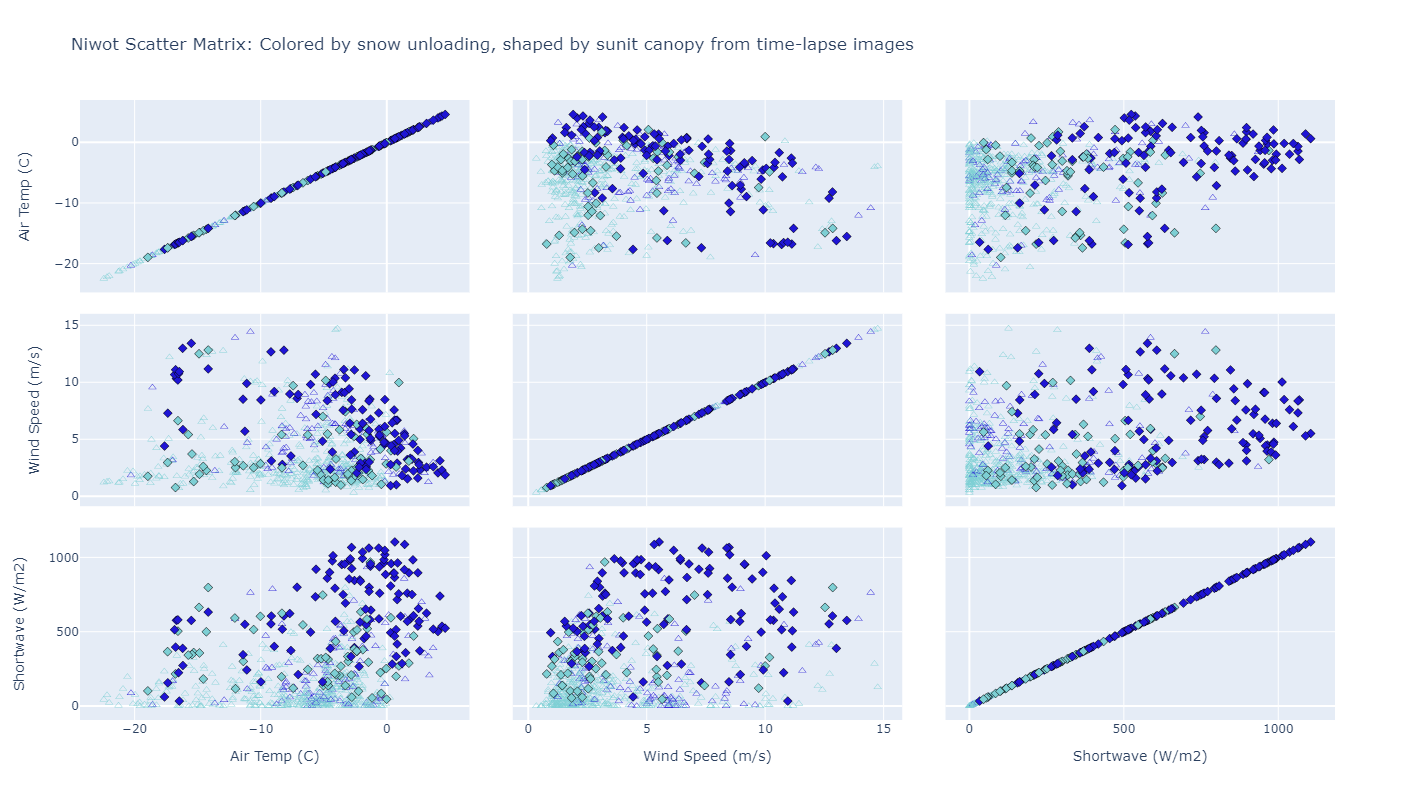

In [45]:
# State which site we are working with 
df = df_unload.copy(deep=True)

# Some constatns 
colorscaled = [[0., colorsnowunload], [1, colorsnow]]
# index_vals = df['A'].astype('category').cat.codes
index_vals = df['CD']
index_symbols = df['Esymbol']

fig = go.Figure()
fig.add_trace(go.Splom(dimensions=[dict(label='Air Temp (C)',     values=df['temp']),
                                   dict(label='Wind Speed (m/s)', values=df['windspeed']),
                                   dict(label='Shortwave (W/m2)', values=df['shortwave'])],
                                   marker=dict(color=index_vals, colorscale=colorscaled, symbol=index_symbols, showscale=False, line_color='black', line_width=0.5, size=7),
                                   showlegend=False,
                      ))

# Other options
#showupperhalf=False, diagonal_visible=False
#marker=dict(show scale=False)

# fig.update_traces(showlegend=True, legendgroup=index_symbols, selector=dict(mode='spolm'))
# fig.update_traces(showlegend=True)

fig.update_layout(title='Niwot Scatter Matrix: Colored by snow unloading, shaped by sunit canopy from time-lapse images', width=1000, height=800, dragmode='select')

fig.show()

## open square for cloudy, diamond dot for sunny, open circle for no radiation data